In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Data
Loading the preprocessed dataset.

In [28]:
df = pd.read_csv('../datasets/wb_usa_real_gdp_yearly.csv', parse_dates=['timestamp'], index_col='timestamp')

# Convert to billions
df['real_gdp'] = df['real_gdp'] / 1e9

print(df.head())
print(df.info())
print(df.describe())

               real_gdp
timestamp              
1960-01-01  3414.529777
1961-01-01  3493.063962
1962-01-01  3706.140864
1963-01-01  3869.211062
1964-01-01  4093.625304
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 1960-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   real_gdp  65 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB
None
           real_gdp
count     65.000000
mean   11251.958924
std     5618.068855
min     3414.529777
25%     6185.752592
50%    10069.725931
75%    16233.167951
max    22568.462768


## 2. Time Series Plot
Visualizing the Real GDP over time allows us to identify:
- **Trend**: The long-term progression of the series (e.g., increasing or decreasing).
- **Seasonality**: Repeating patterns or cycles over time.
- **Outliers**: Unusual data points that deviate significantly from the rest.
- **Structural Breaks**: Sudden changes in the trend or mean.

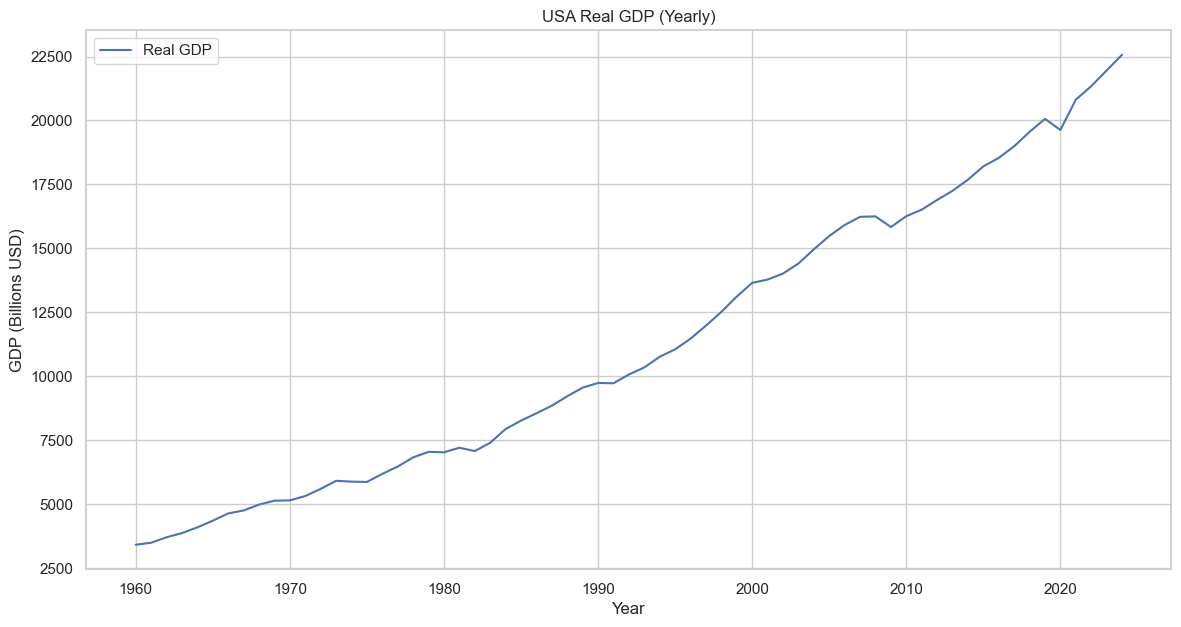

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['real_gdp'], label='Real GDP')
plt.title('USA Real GDP (Yearly)')
plt.xlabel('Year')
plt.ylabel('GDP (Billions USD)')
plt.legend()
plt.show()

## 3. Decomposition (Hodrick-Prescott Filter)
Since we are working with **yearly data**, standard seasonal decomposition (which looks for monthly or quarterly patterns) is not applicable as there is no sub-year seasonality.

Instead, we use the **Hodrick-Prescott (HP) Filter** to decompose the time series into:
- **Trend**: The long-term growth component.
- **Cycle**: The cyclical component (e.g., business cycles) representing deviations from the trend.

We use a smoothing parameter ($\lambda$) of **6.25**, which is recommended for yearly data.

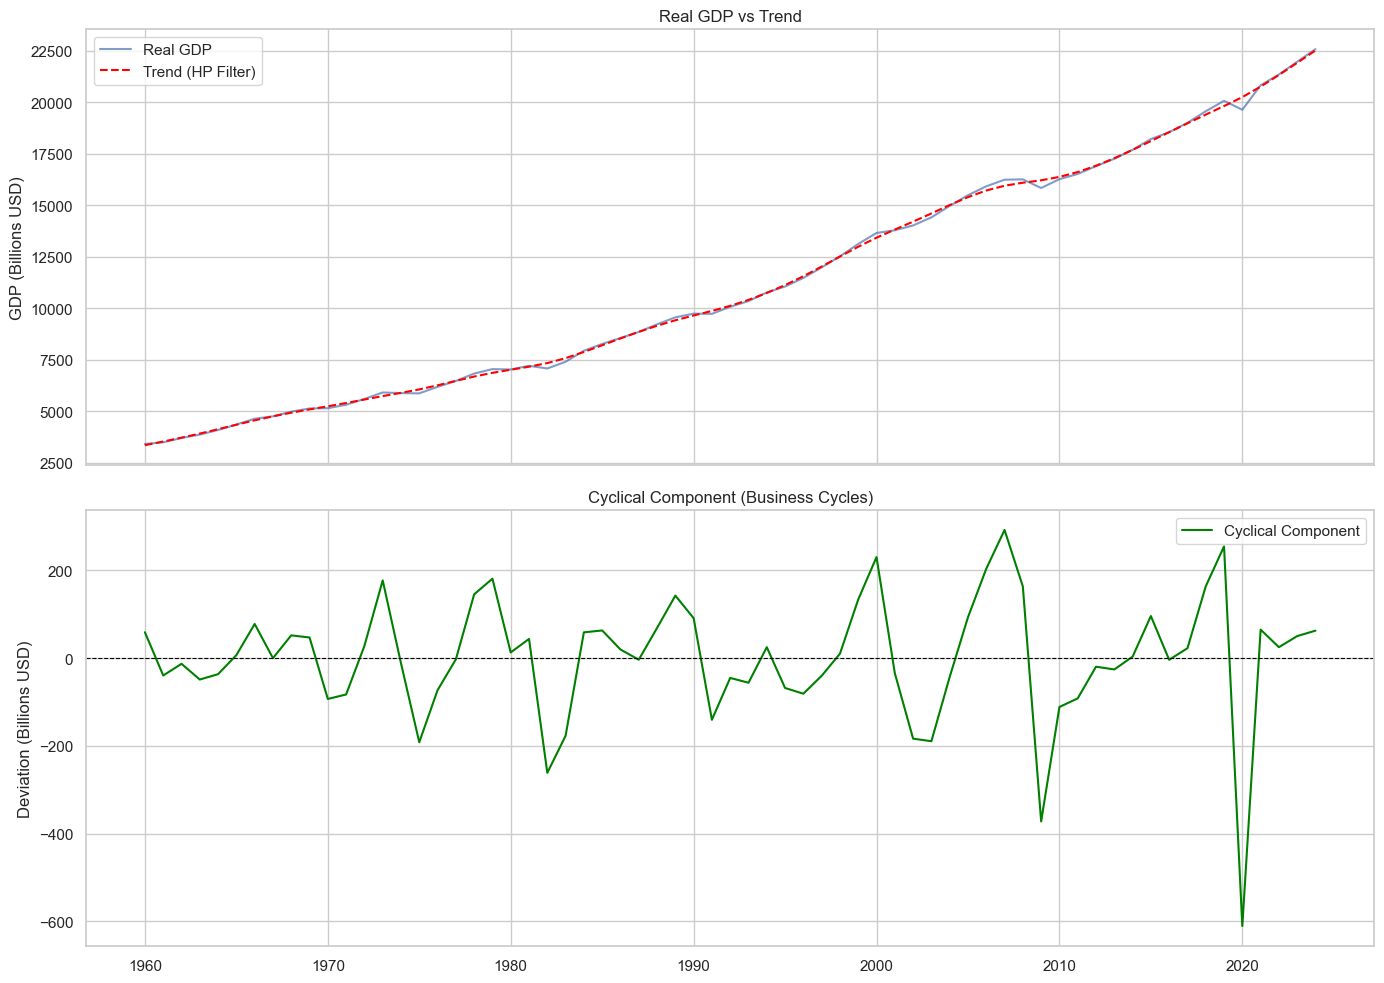

               Real GDP        Trend      Cycle
timestamp                                      
1960-01-01  3414.529777  3355.823458  58.706320
1961-01-01  3493.063962  3532.896686 -39.832724
1962-01-01  3706.140864  3719.362926 -13.222062
1963-01-01  3869.211062  3918.241952 -49.030890
1964-01-01  4093.625304  4130.438010 -36.812706


In [30]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Apply Hodrick-Prescott filter
# lambda=6.25 is recommended for yearly data
cycle, trend = hpfilter(df['real_gdp'], lamb=6.25)

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Original Data vs Trend
ax[0].plot(df.index, df['real_gdp'], label='Real GDP', alpha=0.7)
ax[0].plot(df.index, trend, label='Trend (HP Filter)', color='red', linestyle='--')
ax[0].set_title('Real GDP vs Trend')
ax[0].set_ylabel('GDP (Billions USD)')
ax[0].legend()

# Cyclical Component
ax[1].plot(df.index, cycle, label='Cyclical Component', color='green')
ax[1].set_title('Cyclical Component (Business Cycles)')
ax[1].set_ylabel('Deviation (Billions USD)')
ax[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
ax[1].legend()

plt.tight_layout()
plt.show()

# Display first few rows of trend and cycle
decomposition_df = pd.DataFrame({'Real GDP': df['real_gdp'], 'Trend': trend, 'Cycle': cycle})
print(decomposition_df.head())

## 4. Autocorrelation and Partial Autocorrelation
- **Autocorrelation Function (ACF)**: Measures the correlation between the time series and its lagged values. It helps identify the Moving Average (MA) part of an ARIMA model.
- **Partial Autocorrelation Function (PACF)**: Measures the correlation between the time series and its lagged values, controlling for the values of the time series at all shorter lags. It helps identify the AutoRegressive (AR) part of an ARIMA model.

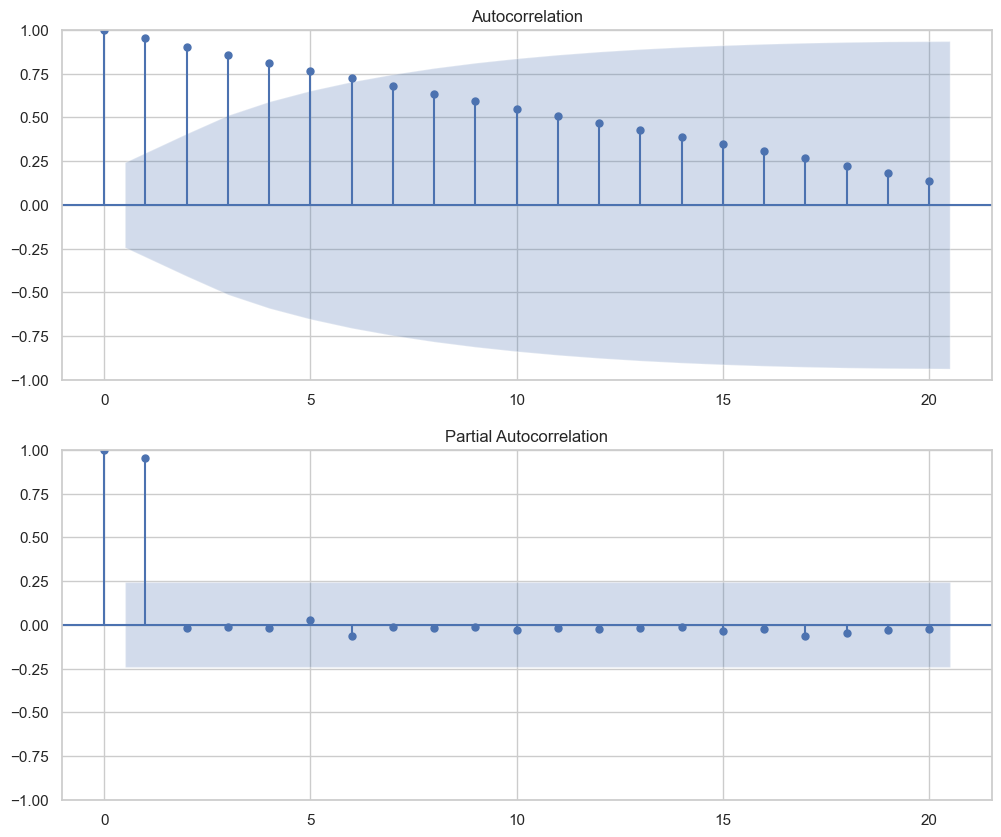

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df['real_gdp'], ax=ax[0], lags=20)
plot_pacf(df['real_gdp'], ax=ax[1], lags=20, method='ywm')
plt.show()

## 5. Distribution of Data
Analyzing the distribution of the data helps us understand:
- **Normality**: Whether the data follows a Gaussian distribution (important for many statistical tests).
- **Skewness**: Whether the data is skewed to the left or right.
- **Kurtosis**: The "tailedness" of the distribution.

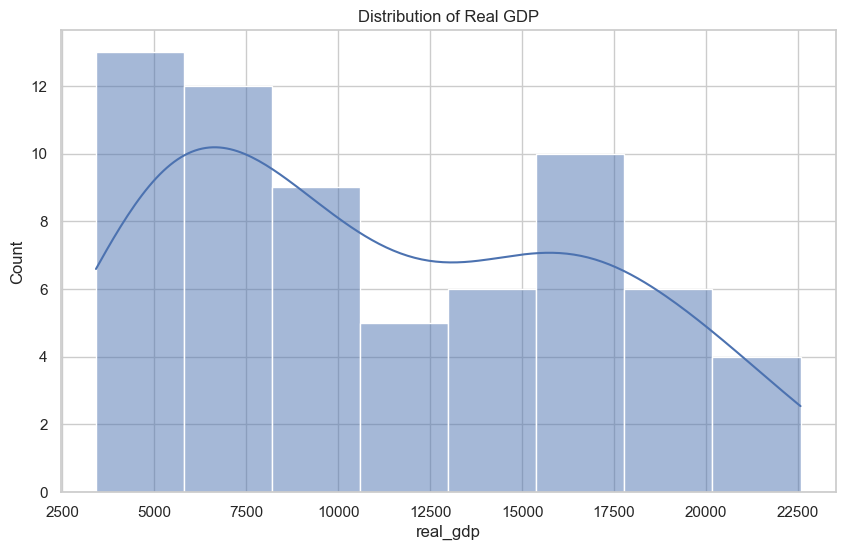

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(df['real_gdp'], kde=True)
plt.title('Distribution of Real GDP')
plt.show()

## 6. Stationarity Test (ADF Test)
Stationarity is a key assumption for many time series forecasting models (like ARIMA). A stationary time series has constant mean, variance, and autocorrelation structure over time.
We use the **Augmented Dickey-Fuller (ADF) test**:
- **Null Hypothesis ($H_0$)**: The time series is non-stationary (has a unit root).
- **Alternative Hypothesis ($H_1$)**: The time series is stationary.
If the p-value is < 0.05, we reject the null hypothesis and conclude the series is stationary.

In [33]:
result = adfuller(df['real_gdp'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] < 0.05:
    print("Reject the null hypothesis. Data is stationary.")
else:
    print("Fail to reject the null hypothesis. Data is non-stationary.")

ADF Statistic: 3.2102647696869475
p-value: 1.0
Critical Values:
	1%: -3.53692771987915
	5%: -2.907887369384766
	10%: -2.591493291015625
Fail to reject the null hypothesis. Data is non-stationary.


## 7. Differencing (if non-stationary)
If the time series is non-stationary, we can apply **differencing** to stabilize the mean.
- **First Difference**: $y'_t = y_t - y_{t-1}$. This represents the change or growth from one period to the next.
After differencing, we re-test for stationarity.

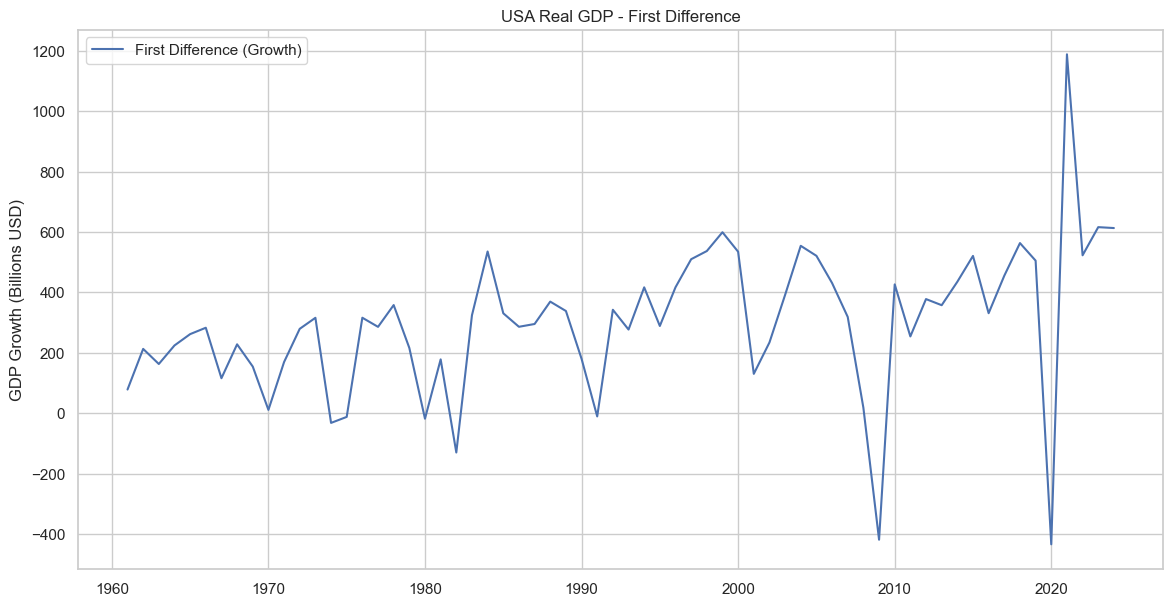

ADF Statistic (Diff): -0.9168711741142623
p-value (Diff): 0.7823657380319817


In [34]:
df['gdp_diff'] = df['real_gdp'].diff()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['gdp_diff'], label='First Difference (Growth)')
plt.title('USA Real GDP - First Difference')
plt.ylabel('GDP Growth (Billions USD)')
plt.legend()
plt.show()

# Check stationarity of differenced data
df_diff = df['gdp_diff'].dropna()
result_diff = adfuller(df_diff)
print('ADF Statistic (Diff):', result_diff[0])
print('p-value (Diff):', result_diff[1])